In [2]:
!pip install matplotlib transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 72.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 140.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 137.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


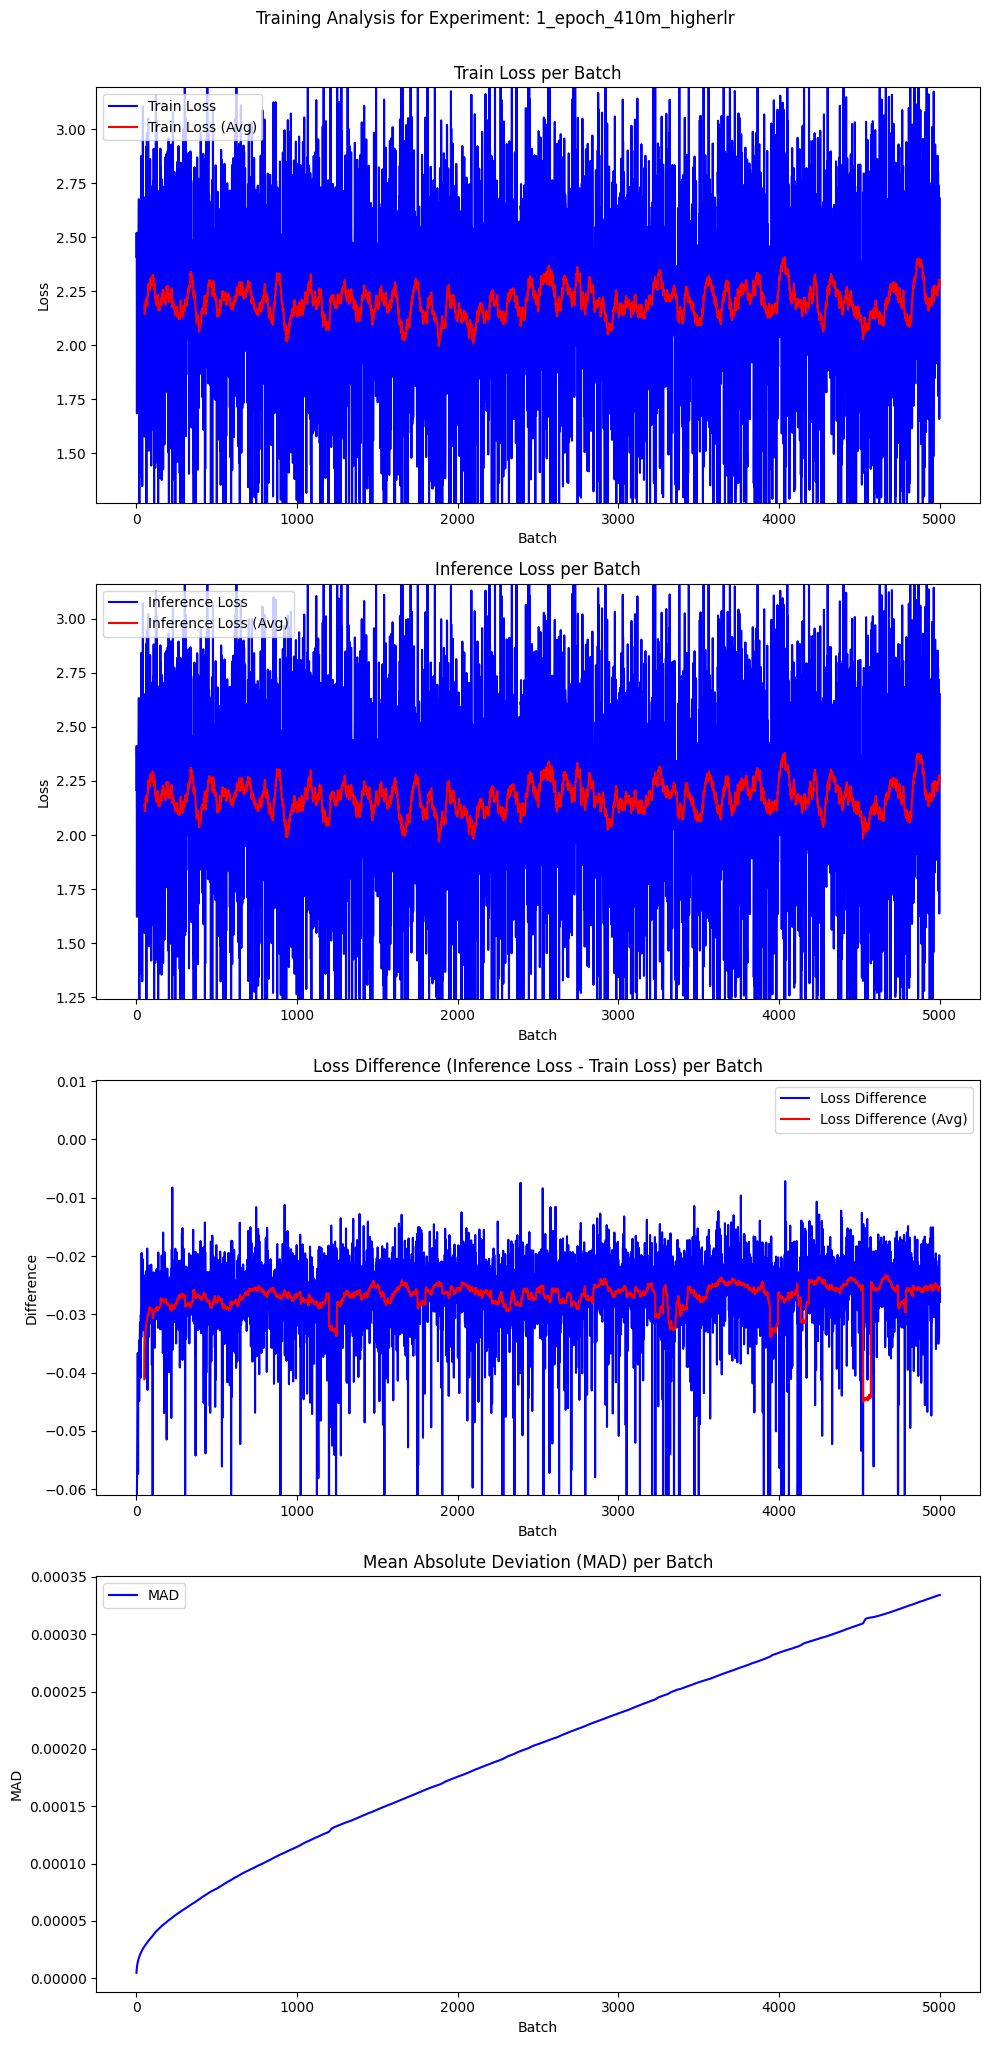

Analysis complete. Plots saved to experiments/1_epoch_410m_higherlr/training_analysis.png


In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

def load_config(config_path):
    with open(config_path, 'r') as cfg_file:
        return json.load(cfg_file)

def calculate_y_limits(series, std_multiplier=2):
    median = series.median()
    std = series.std()
    lower_limit = median - std_multiplier * std
    upper_limit = median + std_multiplier * std
    return lower_limit, upper_limit

def analyze_results(config_path):
    # Load the configuration file
    cfg = load_config(config_path)
    
    # Get the paths
    exp_dir = os.path.join('experiments', cfg["experiment_name"])
    csv_file_path = os.path.join(exp_dir, "batch_training_results.csv")
    
    # Load the results CSV
    results_df = pd.read_csv(csv_file_path)
    
    # Calculate rolling averages
    window_size = 50  # You can adjust this window size as needed
    results_df['train_loss_avg'] = results_df['train_loss'].rolling(window=window_size).mean()
    results_df['inference_loss_avg'] = results_df['inference_loss'].rolling(window=window_size).mean()
    
    # Calculate the difference between inference loss and training loss
    results_df['loss_diff'] = results_df['inference_loss'] - results_df['train_loss']
    results_df['loss_diff_avg'] = results_df['loss_diff'].rolling(window=window_size).mean()
    
    # Calculate y-axis limits
    train_loss_limits = calculate_y_limits(results_df['train_loss'])
    inference_loss_limits = calculate_y_limits(results_df['inference_loss'])
    loss_diff_limits = calculate_y_limits(results_df['loss_diff'])
    
    # Plot the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))
    
    # Plot Train Loss
    axes[0].plot(results_df['batch'], results_df['train_loss'], label='Train Loss', color='blue')
    axes[0].plot(results_df['batch'], results_df['train_loss_avg'], label='Train Loss (Avg)', color='red')
    axes[0].set_ylim(train_loss_limits)
    axes[0].set_title('Train Loss per Batch')
    axes[0].set_xlabel('Batch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot Inference Loss
    axes[1].plot(results_df['batch'], results_df['inference_loss'], label='Inference Loss', color='blue')
    axes[1].plot(results_df['batch'], results_df['inference_loss_avg'], label='Inference Loss (Avg)', color='red')
    axes[1].set_ylim(inference_loss_limits)
    axes[1].set_title('Inference Loss per Batch')
    axes[1].set_xlabel('Batch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    
    # Plot Loss Difference (Inference Loss - Train Loss)
    axes[2].plot(results_df['batch'], results_df['loss_diff'], label='Loss Difference', color='blue')
    axes[2].plot(results_df['batch'], results_df['loss_diff_avg'], label='Loss Difference (Avg)', color='red')
    axes[2].set_ylim(loss_diff_limits)
    axes[2].set_title('Loss Difference (Inference Loss - Train Loss) per Batch')
    axes[2].set_xlabel('Batch')
    axes[2].set_ylabel('Difference')
    axes[2].legend()
    
    # Plot MAD
    axes[3].plot(results_df['batch'], results_df['overall_mad'], label='MAD', color='blue')
    axes[3].set_title('Mean Absolute Deviation (MAD) per Batch')
    axes[3].set_xlabel('Batch')
    axes[3].set_ylabel('MAD')
    axes[3].legend()
    
    plt.tight_layout()
    
    # Save the plot in the experiment folder
    plot_save_path = os.path.join(exp_dir, "training_analysis.png")
    plt.suptitle(f"Training Analysis for Experiment: {cfg['experiment_name']}", y=1.02)
    plt.savefig(plot_save_path)
    plt.show()

    print(f"Analysis complete. Plots saved to {plot_save_path}")

# Run the analysis
analyze_results('config.json')


In [5]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

def extract_metrics(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    results = data.get('results', {})
    metrics = {}
    for task, task_results in results.items():
        for metric, value in task_results.items():
            metrics[f"{task}_{metric}"] = value
    metrics['model'] = data.get('model_name_sanitized', '')
    metrics['original_model_name'] = data.get('model_name', '')
    return metrics

def gather_metrics(results_dir):
    all_metrics = []
    original_model_metrics = None

    for file in os.listdir(results_dir):
        if file.endswith(".json"):
            json_file = os.path.join(results_dir, file)
            metrics = extract_metrics(json_file)
            try:
                epoch_str = metrics['model'].split('__')[-1].split('_')[-1]
                metrics['epoch'] = int(epoch_str)
            except ValueError:
                metrics['epoch'] = None
                original_model_metrics = metrics
                continue
            all_metrics.append(metrics)

    if original_model_metrics:
        original_model_metrics['epoch'] = -1  # Ensure the original model is the first point
        all_metrics.insert(0, original_model_metrics)

    if not all_metrics:
        print("No valid metrics found. Exiting.")
        return pd.DataFrame()  # Return empty DataFrame if no metrics were found

    df = pd.DataFrame(all_metrics)
    df.dropna(how='all', subset=[col for col in df.columns if col not in ['epoch', 'model', 'original_model_name']], inplace=True)
    return df

def plot_metrics(df, output_dir):
    for column in df.columns:
        if column in ['epoch', 'model', 'original_model_name']:
            continue
        plt.figure(figsize=(10, 6))
        try:
            plt.plot(df['epoch'], df[column].astype(float), marker='o', linestyle='-')
        except ValueError:
            continue  # Skip plotting if conversion to float fails
        plt.xlabel('Epoch')
        plt.ylabel(column)
        plt.title(f'{column} over Epochs')
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, f'{column}_over_epochs.png'))
        plt.close()

def main(results_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    df_metrics = gather_metrics(results_dir)
    if df_metrics.empty:
        return

    # Print out all model names found
    print("Model names found:")
    for model_name in df_metrics['original_model_name'].unique():
        print(model_name)

    df_metrics.sort_values(by='epoch', inplace=True, na_position='last')
    
    output_csv = os.path.join(output_dir, 'evaluation_metrics.csv')
    df_metrics.to_csv(output_csv, index=False)
    print(f"Metrics saved to {output_csv}")
    
    plot_metrics(df_metrics, output_dir)

if __name__ == "__main__":
    results_dir = '/workspace/slice-monorepo/sub_validations/cl_scaling/dnd/experiments/1e3/llm_eval/all_results'  # Path to the folder containing JSON result files
    output_dir = 'analysis_llmeval'  # Directory to save the analysis results

    main(results_dir, output_dir)


Model names found:
EleutherAI/pythia-70m
experiments/1e3/llm_eval/model_epoch_7001
experiments/1e3/llm_eval/model_epoch_7000
experiments/1e3/llm_eval/model_epoch_6620
experiments/1e3/llm_eval/model_epoch_4965
experiments/1e3/llm_eval/model_epoch_3310
experiments/1e3/llm_eval/model_epoch_1655
Metrics saved to analysis_llmeval/evaluation_metrics.csv


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>